In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
classes = { "WWewk": 0, "top":1 }
signal_name = "WWewk"
sample_names = ["WWewk", "top"]

In [3]:
samples = {}

In [4]:
base_dir="/eos/home-b/bpinolin/ML_output/"
plot_config="VBSOS"
cut= "sr"
version = "highZ_test"

In [5]:
output_dir = os.path.join(base_dir, plot_config, cut, "samples/", version)

In [6]:
datasets  = ["2016","2017","2018"]
samples_dirs = [os.path.join(base_dir, plot_config, cut, "samples/", version, p) for p in datasets]

In [7]:
lumi = { 2016: 35.867, 2017: 41.5 , 2018: 59.74}

In [8]:
for samples_dir in samples_dirs:
    for file in os.listdir(samples_dir):
        if os.path.isdir(os.path.join(samples_dir, file)): continue
        sname = file.split("_part")[0]
        print(sname)
        s = pickle.load(open(os.path.join(samples_dir, file), "rb"))
        s.rename(columns=lambda c: c.split(cut+"_")[1] if cut in c else c, inplace=True)
        s["sample_name"]= sname
        s["class"] = classes[sname]
        if sname == signal_name:
            s["signal"] = 1
        else: 
            s["signal"] = 0
            
            
        if "2016" in samples_dir:
            s["year"] = 2016
            s["weight_"] = s["weight_"] * lumi[2016] #lumi is included 
        if "2017" in samples_dir:
            s["year"] = 2017
            s["weight_"] = s["weight_"] * lumi[2017] #lumi is included 
        if "2018" in samples_dir:
            s["year"] = 2018 
            s["weight_"] = s["weight_"] * lumi[2018] #lumi is included 
            
        if sname in samples:
            samples[sname] = pd.concat([samples[sname], s], ignore_index=True)
        else:
            samples[sname] = s

WWewk
top
top
WWewk
top
top
WWewk
top
top


In [9]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.weight_).sum():15}")

Sample name WWewk     , nsamples:      10280,   XS total: 155.87593231285257
Sample name top       , nsamples:      76486,   XS total: 9312.109141581177


In [10]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.preprocessing import LabelEncoder 

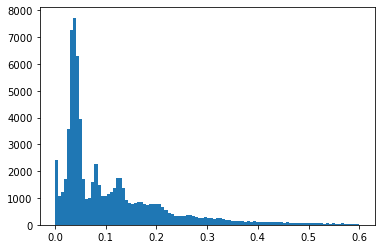

In [11]:
 _ = plt.hist(samples["top"]["weight_"], bins=100, range=(0,0.6))

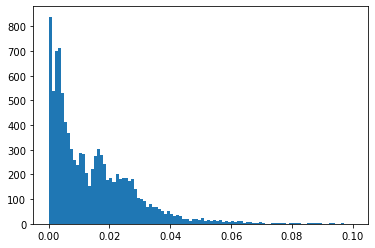

In [12]:
 _ = plt.hist(samples["WWewk"]["weight_"], bins=100, range=(0,0.1))

# Balancing

In [13]:
bkg_list = []
bkg_names = [ name for name in sample_names if name != signal_name ]
for bkg_name in bkg_names:
    bkg_list.append(samples[bkg_name])

In [14]:
background = pd.concat(bkg_list, ignore_index=True)

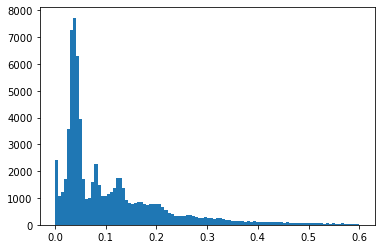

In [15]:
 _ = plt.hist(background['weight_'], bins=100, range=(0,0.6))

In [16]:
signal = samples["WWewk"]

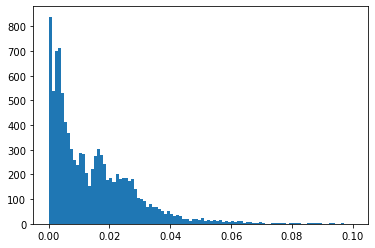

In [17]:
 _ = plt.hist(signal['weight_'], bins=100, range=(0,0.1))

In [18]:
ratio_neve_bkgsignal= len(background) / len(signal)
print(ratio_neve_bkgsignal)

7.440272373540856


In [19]:
tot_ev_weighted_sig = (signal.weight_ / signal.weight_.mean()).sum()
print("TOT signal weighted events", tot_ev_weighted_sig)

TOT signal weighted events 10280.0


In [20]:
rescale_factor_bkg = (tot_ev_weighted_sig *ratio_neve_bkgsignal )/ background.weight_.sum()
print(rescale_factor_bkg)

8.21360648131459


In [21]:
signal["weight_norm"] = signal.weight_ / signal.weight_.mean()
background["weight_norm"] = background.weight_ * rescale_factor_bkg

# Save signal and bkg samples

In [22]:
import os

os.makedirs(os.path.join(output_dir, "for_training"), exist_ok=True)
pickle.dump(background, open(os.path.join(output_dir, "for_training/background_balanced.pkl"), "wb"))
pickle.dump(signal, open(os.path.join(output_dir, "for_training/signal_balanced.pkl"), "wb"))

In [23]:
print("Effective sig events: ", signal.weight_norm.sum())
print("Effective bkg events: ", background.weight_norm.sum())

Effective sig events:  10280.0
Effective bkg events:  76486.00000000001


In [24]:
print("XS Signal = ", round((signal.weight_).sum(),1))
print("XS Background = ", round((background.weight_).sum(),1))

XS Signal =  155.9
XS Background =  9312.1


In [25]:
len(signal)

10280

In [26]:
len(background)

76486

In [27]:
sig_low = 24586
bkg_low = 98578

sig_tot = 100 * sig_low / 51
bkg_tot = 100 * bkg_low / 3.9

In [28]:
int(sig_tot)

48207

In [29]:
int(bkg_tot)

2527641

In [34]:
10280/48207

0.21324703881179083

In [35]:
76486/2527641

0.030259835158552975